In [1]:
# Imports and hyperparams
%matplotlib inline
import os
import cv2
import numpy as np
import scipy.io as sio
from DenseDepthModel import DenseDepth
from DORN import DORN
from MiDaSModel import get_midas, midas_predict
from capture_utils import loadmat_h5py, z_to_r_kinect, r_to_z_kinect, rescale_bins, normals_from_depth
from models.data.data_utils.sid_utils import SID
from remove_dc_from_spad import remove_dc_from_spad_edge
from weighted_histogram_matching import image_histogram_match
# from spad_utils import rescale_bins
import h5py
import matplotlib.pyplot as plt
rootdir = "data/8_29_kitchen_scene"

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

loaded_orig = False

Using TensorFlow backend.


No relevant file, loading original from data/8_29_kitchen_scene/spad/data_accum.mat


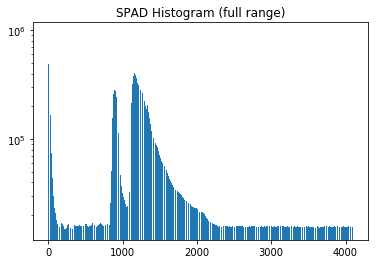

In [2]:
# Load SPAD data
relevant_file = os.path.join(rootdir, "spad_relevant.npy")
force_refresh = False
if os.path.isfile(relevant_file) and not force_refresh:
    print("Loading from {}".format(relevant_file))
    spad_relevant_dict = np.load(relevant_file, allow_pickle=True)
    spad_relevant = spad_relevant_dict["spad_relevant"]
    min_depth_bin = spad_relevant_dict["min_depth_bin"]
    max_depth_bin = spad_relevant_dict["max_depth_bin"]
else:
    orig_file = os.path.join(rootdir, "spad", "data_accum.mat")
    print("No relevant file, loading original from {}".format(orig_file))
    spad = loadmat_h5py(orig_file)
    # No relevant file yet, so plotting:
    spad_single = np.sum(spad["mat"], axis=(0,1))
    plt.bar(range(len(spad_single)), spad_single, log=True)
    plt.title("SPAD Histogram (full range)")
    loaded_orig = True
#     spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
#     np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant)


Saving to data/8_29_kitchen_scene/spad_relevant.npy
min depth, max_depth
1.68 5.7623999999999995
700 2400


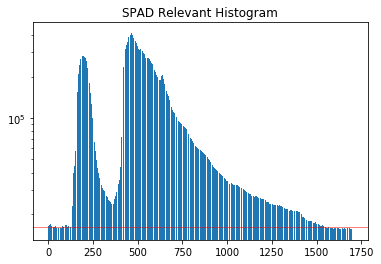

In [4]:
# Inspect SPAD, set min and max depths, and set the ambient estimate
# Extract relevant subset of SPAD and save
bin_width_ps = 16  # Bin width is 16 ps
bin_width_m = bin_width_ps*3e8/(2*1e12)
if loaded_orig:
    # Adjust parameters here
    min_depth_bin = 700
    max_depth_bin = 2400
    spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
    spad_relevant_dict = {
        "spad_relevant": spad_relevant,
        "min_depth_bin": min_depth_bin,
        "max_depth_bin": max_depth_bin
    }
    print("Saving to {}".format(os.path.join(rootdir, "spad_relevant.npy")))
    np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant_dict)
min_depth = min_depth_bin*bin_width_m
max_depth = (max_depth_bin+1)*bin_width_m
print("min depth, max_depth")
print(min_depth, max_depth)
print(min_depth_bin, max_depth_bin)
    
# Plot to visualize the clipping
spad_single_relevant = np.sum(spad_relevant, axis=(0,1))
plt.bar(range(len(spad_single_relevant)), spad_single_relevant, log=True)
plt.title("SPAD Relevant Histogram")

# Estimate ambient level:
ambient_max_depth = 100
ambient_estimate = np.mean(spad_single_relevant[:ambient_max_depth])
plt.axhline(y=ambient_estimate, color='r', linewidth=0.5)


(3, 510, 510)


/home/markn1/spad_single/nyuv2/captured/capture_utils.py:75: RuntimeWarning: divide by zero encountered in true_divide
  dzdx = (z[:, 2:] - z[:, :-2])/(x[:, 2:] - x[:, :-2])
/home/markn1/spad_single/nyuv2/captured/capture_utils.py:76: RuntimeWarning: divide by zero encountered in true_divide
  dzdy = (z[:-2, :] - z[2:, :])/(y[:-2, :] - y[2:, :])
/home/markn1/spad_single/nyuv2/captured/capture_utils.py:78: RuntimeWarning: invalid value encountered in true_divide
  n /= np.sqrt(np.sum(n**2, axis=0)) # Normalize each vector


Text(0.5, 1.0, 'Normal component')

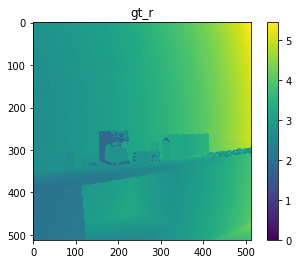

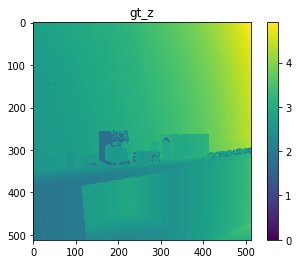

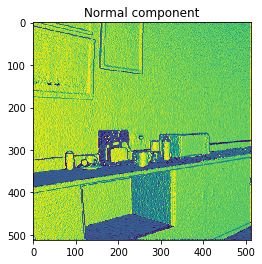

In [5]:
# Get Ground truth depth
import scipy.signal as signal
gt_idx = np.argmax(spad_relevant, axis=2)
gt_r = signal.medfilt(np.fliplr(np.flipud(((gt_idx + min_depth_bin) * bin_width_m).T)), kernel_size=5)
plt.figure()
plt.imshow(gt_r)
plt.title("gt_r")
plt.colorbar()

gt_z = r_to_z_kinect(gt_r)
plt.figure()
plt.imshow(gt_z)
plt.colorbar()
plt.title("gt_z")

# Extract surface normals and compute new weights
gt_n = normals_from_depth(gt_r)
print(gt_n.shape)
normals = np.zeros((gt_n.shape[1]+2, gt_n.shape[2]+2))
normals[1:-1, 1:-1] = gt_n[2,...]
plt.figure()
plt.imshow(normals, vmin=0., vmax=1.)
plt.title("Normal component")




[   0.          7.970459   15.986267   24.04779    32.155396   40.30896
   48.509155   56.75586    65.0495     73.390686   81.779175   90.215576
   98.69989   107.232666  115.813965  124.44403   133.12354   141.85223
  150.63098   159.45935   168.3382    177.2677    186.24805   195.27936
  204.36218   213.49695   222.68335   231.9226    241.21411   250.5586
  259.95648   269.40778   278.9129    288.47223   298.08618   307.75458
  317.4782    327.25726   337.09174   346.98248   356.92963   366.9333
  376.99396   387.112     397.2879    407.52155   417.8133    428.16376
  438.57343   449.04218   459.57062   470.15912   480.8078    491.51727
  502.28778   513.11957   524.01276   534.9683    545.98627   557.0672
  568.211     579.41815   590.6893    602.0246    613.42474   624.88947
  636.4195    648.01544   659.6774    671.4057    683.20074   695.06305
  706.993     718.99115   731.0572    743.1921    755.3963    767.66986
  780.0135    792.4272    804.9119    817.46735   830.0948    842.

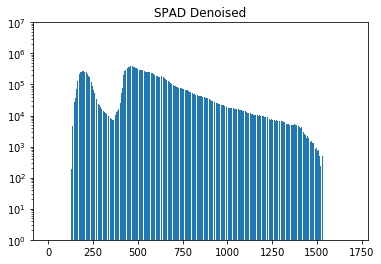

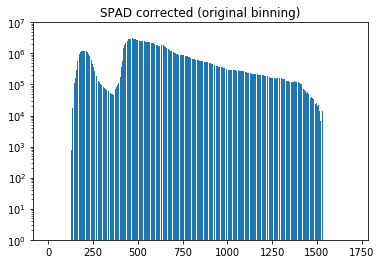

<Figure size 432x288 with 0 Axes>

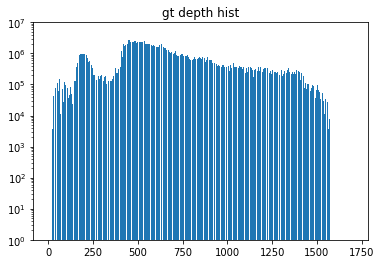

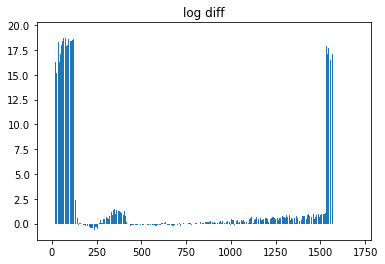

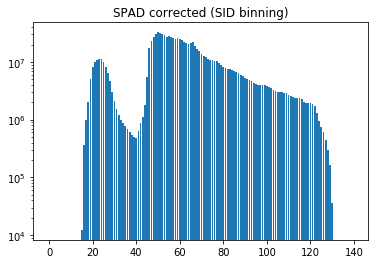

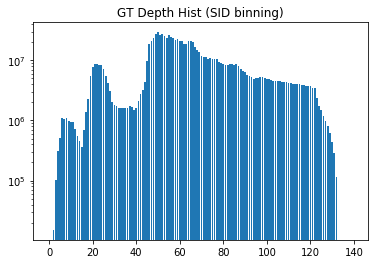

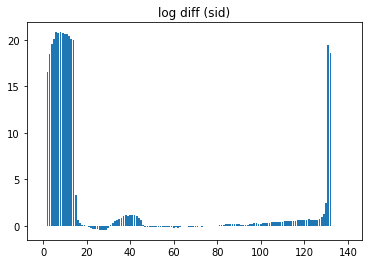

In [6]:
# Preprocess SPAD
sid_obj = SID(sid_bins=140, alpha=min_depth, beta=max_depth, offset=min_depth)

vmin = 1e0
vmax = 1e7

# Remove DC
spad_denoised = remove_dc_from_spad_edge(spad_single_relevant, ambient_estimate)
plt.figure()
plt.bar(range(len(spad_denoised)), spad_denoised, log=True)
plt.ylim(vmin, vmax)
plt.title("SPAD Denoised")

# Correct Falloff
bin_edges = np.linspace(min_depth, max_depth, len(spad_denoised) + 1)
bin_values = (bin_edges[1:] + bin_edges[:-1])/2
spad_corrected = spad_denoised * bin_values ** 2
plt.figure()
plt.bar(range(len(spad_corrected)), spad_corrected, log=True)
plt.ylim(vmin, vmax)
plt.title("SPAD corrected (original binning)")

# GT Depth Histogram for reference
gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
gt_r_hist_scaled = gt_r_hist * np.sum(spad_corrected)/np.sum(gt_r_hist)
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist_scaled, log=True)
plt.ylim(vmin, vmax)
plt.title("gt depth hist")

# Log difference plot for reference:
log_diff = np.log(gt_r_hist_scaled+1e-3) - np.log(spad_corrected+1e-3)
plt.figure()
plt.bar(range(len(log_diff)), log_diff)
plt.title("log diff")

# Convert to SID
spad_sid = rescale_bins(spad_corrected, min_depth, max_depth, sid_obj)
plt.figure()
plt.bar(range(len(spad_sid)), spad_sid, log=True)
plt.title("SPAD corrected (SID binning)");

# GT Depth SID Histogram for reference
gt_r_hist_sid = rescale_bins(gt_r_hist_scaled, min_depth, max_depth, sid_obj)
plt.figure()
plt.bar(range(len(gt_r_hist_sid)), gt_r_hist_sid, log=True)
plt.title("GT Depth Hist (SID binning)");

# Log diff sid
log_diff_sid = np.log(gt_r_hist_sid + 1e-3) - np.log(spad_sid + 1e-3)
plt.figure()
plt.bar(range(len(log_diff_sid)), log_diff_sid)
plt.title("log diff (sid)");


In [17]:
print(np.sort(np.nonzero(spad_sid))[0][-4:])
print(log_diff_sid[-20:])

[127 128 129 130]
[ 0.62261187  0.61089961  0.70026204  0.59476389  0.60970749  0.67241362
  0.66006617  0.79239059  0.97915737 20.24118855 19.8823954  19.49184497
 18.54975072  0.          0.          0.          0.          0.
  0.          0.        ]


Text(0.5, 1.0, 'SPAD Deconvolved')

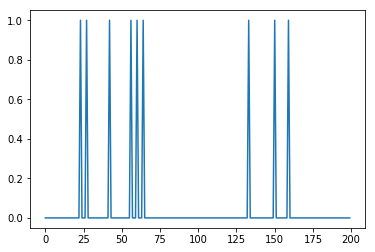

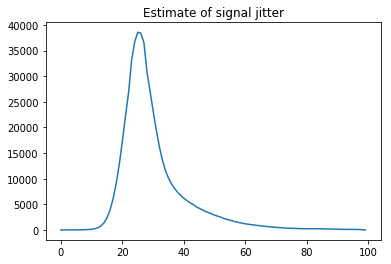

<Figure size 432x288 with 0 Axes>

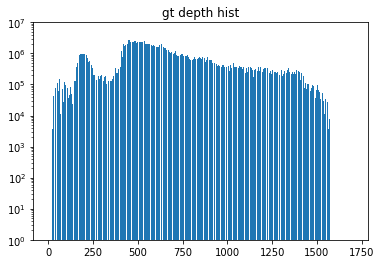

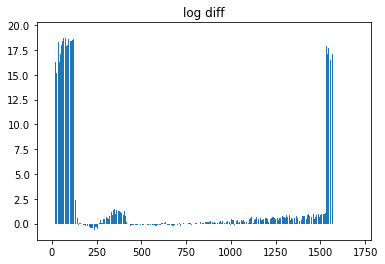

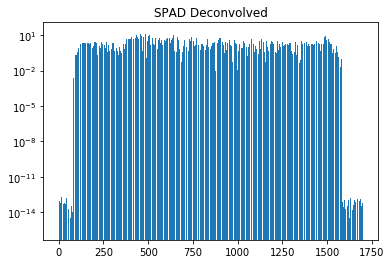

In [9]:
# Deconvolve using ground truth SPAD waveform.
import scipy.signal as signal
from scipy.signal import fftconvolve
plt.figure()
single_pixel = spad_relevant[30, 30, :]
plt.plot(single_pixel[200:400])

# Align a bunch of histograms and average them
# Alignment
jitter_length = 100
win = (0, 100, 0, 100)
maxima = np.argmax(spad_relevant[win[0]:win[1], win[2]:win[3], :], axis=2)
max_values = np.max(spad_relevant[win[0]:win[1], win[2]:win[3], :], axis=2)
jitter = np.zeros((maxima.shape[0], maxima.shape[1], jitter_length))
for i in range(win[1] - win[0]):
    for j in range(win[3] - win[2]):
        start = maxima[i, j] - 25 # arbitrary
        end = maxima[i, j] + 75
        jitter[i,j,:] = signal.medfilt(spad_relevant[i+win[0], j+win[2], start:end]/max_values[i, j], 5)
        

# Averaging
jitter_est = np.mean(jitter, axis=(0,1))
jitter_est = jitter_est/np.min(jitter_est)
plt.figure()
plt.plot(jitter_est)
plt.title("Estimate of signal jitter")

# Deconvolution (Wiener Filter)
from scipy.fftpack import fft, ifft

def wiener_filt_1d(signal, kernel, snr=1e3):
    # Zero-pad
    assert len(signal) > len(kernel)
    H = fft(kernel)
    # X = fft(spad_corrected)
    snr = 1e3 # Arbitrary
    G = 1/H * (np.abs(H)**2/(np.abs(H)**2 + 1./snr))
    g = np.real(ifft(G))
    # Zero pad signal, then remove extra terms
    return fftconvolve(signal, g, mode='same')
    

    
# GT Depth Histogram for reference
gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
gt_r_hist_scaled = gt_r_hist * np.sum(spad_corrected)/np.sum(gt_r_hist)
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist_scaled, log=True)
plt.ylim(vmin, vmax)
plt.title("gt depth hist")

# Log difference plot for reference:
log_diff = np.log(gt_r_hist_scaled+1e-3) - np.log(spad_corrected+1e-3)
plt.figure()
plt.bar(range(len(log_diff)), log_diff)
plt.title("log diff")

spad_deconv = np.abs(wiener_filt_1d(spad_corrected, jitter_est))
# print(spad_deconv.shape)
plt.figure()
plt.bar(range(len(spad_deconv)), spad_deconv, log=True)
plt.title("SPAD Deconvolved")

# # GT Depth Histogram for reference
# gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
# plt.figure()
# gt_r_hist_scaled = gt_r_hist * np.sum(spad_deconv)/np.sum(gt_r_hist)
# plt.figure()
# plt.bar(range(len(gt_r_hist)), gt_r_hist_scaled, log=True)
# plt.title("gt depth hist")

# # Log difference plot for reference:
# log_diff = np.log(gt_r_hist_scaled[:len(spad_deconv)]+1e-3) - np.log(spad_deconv+1e-3)
# plt.figure()
# plt.bar(range(len(log_diff)), log_diff)
# plt.title("log diff")




100
100
[ 0.08295899  0.03787459 -0.04715153 -0.08004909 -0.00776762  0.07103072
  0.06062915 -0.02050739 -0.08298535 -0.03838128  0.05606711  0.07610581
  0.00730445 -0.07709486 -0.06505696  0.03488895  0.08470156  0.03410811
 -0.06320334 -0.08539078  0.00962194  0.08514561  0.05825278 -0.04392452
 -0.09668674 -0.01639854  0.07642621  0.07654696 -0.02010623 -0.09789531
 -0.0400242   0.05842366  0.08673426  0.00772576 -0.08997752 -0.05964897
  0.03402936  0.08773087  0.03581979 -0.07280169 -0.07336033  0.00591116
  0.07831682  0.06193912 -0.04701379 -0.08078208 -0.02286492  0.05806156
  0.08510948 -0.01476556 -0.08289877 -0.05084931  0.03399951  0.10247891
  0.01375388 -0.07382398 -0.07264202  0.00421519  0.11120167  0.03952573
 -0.0577741  -0.0847453  -0.03084981  0.11228075  0.06319465 -0.03684272
 -0.08711319 -0.06870034  0.10677437  0.08201445 -0.01462766 -0.08447695
 -0.09995719  0.09747062  0.08971988  0.00547395 -0.08032351 -0.07094973
  0.01972455  0.09603829  0.04283613 -0.062

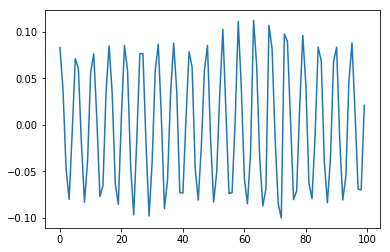

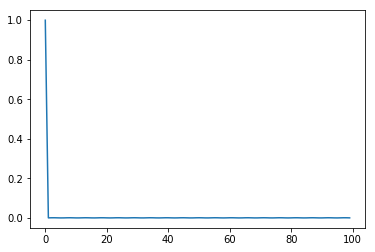

In [144]:
# Playing with Wiener Filtering
from scipy.fftpack import fft, ifft, fftshift
from scipy.signal import fftconvolve

def circconvolve(s, k):
    """Returns something same length as s"""
    assert len(k) <= len(s)
    arr = fftconvolve(k, np.concatenate((s,s)))
    return arr[len(s):2*len(s)]
H = fft(jitter_est)
# X = fft(spad_corrected)
snr = 1e3 # Arbitrary
G = 1/H * (np.abs(H)**2/(np.abs(H)**2 + 1./snr))
g = ifft(G)
plt.figure()
plt.plot(g)
d = circconvolve(g, jitter_est)
plt.figure()
plt.plot(d)
print(len(g))
print(len(jitter_est))
print(np.real(g))

Loading calibration data...
Loading kinect data...
17
28


(-0.5, 859.5, 784.5, -0.5)

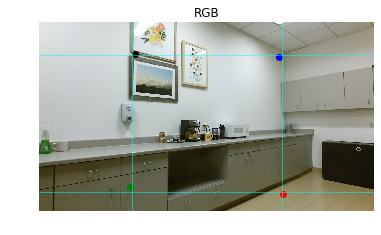

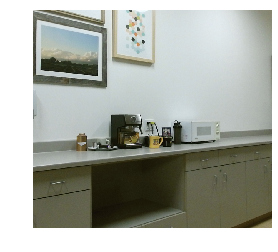

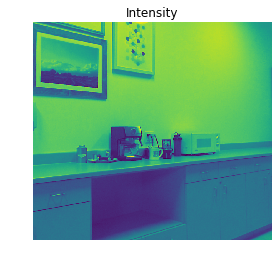

In [10]:
# RGB Images
# Calibration data
print("Loading calibration data...")
calib = loadmat_h5py(os.path.join(rootdir, "calibration.mat"))

print("Loading kinect data...")
kinect = loadmat_h5py(os.path.join(rootdir, "kinect.mat"))
# Transpose and visualize
plt.figure()
kinect_rgb = np.fliplr(kinect["rgb_im"].transpose(2, 1, 0))
plt.imshow(kinect_rgb)
plt.title("RGB")
plt.axis("off")
plt.plot(calib["pos_00"][1], calib["pos_00"][0], "ro")
plt.plot(calib["pos_01"][1], calib["pos_01"][0], "bo")
plt.plot(calib["pos_10"][1], calib["pos_10"][0], "go")
plt.plot(calib["pos_11"][1], calib["pos_11"][0], "ko")

# print(calib["pos_00"]) # position 0 is the row, position 1 is the column
# Extract crop
top = (calib["pos_01"][0] + calib["pos_11"][0])//2
bot = (calib["pos_10"][0] + calib["pos_00"][0])//2
left = (calib["pos_11"][1] + calib["pos_10"][1])//2
right = (calib["pos_01"][1] + calib["pos_00"][1])//2

# Scene-specific crop
crop = (int(top[0])-6, int(bot[0])+6, int(left[0])-5, int(right[0])+4)
print((crop[1] - crop[0]) % 32)
print((crop[3] - crop[2]) % 32)
plt.axhline(y=crop[0], color='cyan', linewidth=0.5)
plt.axhline(y=crop[1], color='cyan', linewidth=0.5)
plt.axvline(x=crop[2], color='cyan', linewidth=0.5)
plt.axvline(x=crop[3], color='cyan', linewidth=0.5)

# Kinect Depth - don't use for now
# plt.figure()
# kinect_depth = np.fliplr(kinect["depth_im"].transpose(1, 0))
# plt.imshow(kinect_depth)
# plt.title("Kinect Depth")
# plt.axis("off");

# Crop
rgb_cropped = kinect_rgb[crop[0]:crop[1], crop[2]:crop[3], :]
plt.figure()
plt.imshow(rgb_cropped)
plt.axis("off")

# Intensity
intensity = rgb_cropped[:,:,0]/225.
plt.figure()
plt.imshow(intensity)
plt.title("Intensity")
plt.axis("off")

0.9585831405580489
0.792462562228573
0.8533333333333334
0.8488888888888889


ValueError: operands could not be broadcast together with shapes (512,512) (785,860) 

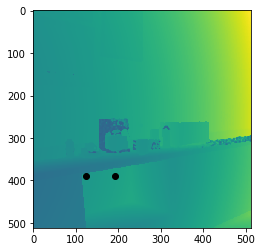

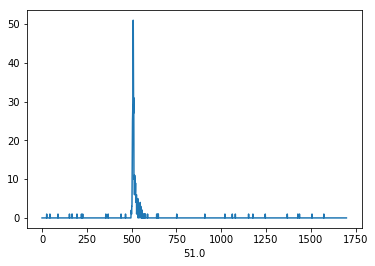

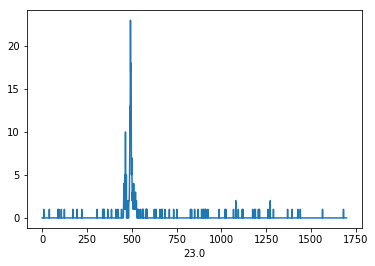

In [11]:
# Investigate two points with same depth but different angles
# plt.plot(gt_r[390,:250])
plt.imshow(gt_r)

pt1 = (390, 125) # (Y, X)
pt2 = (390, 192)

plt.plot(pt1[1], pt1[0], "ko")
plt.plot(pt2[1], pt2[0], "ko")

hist1 = spad_relevant[pt1[0], pt1[1], :]
hist2 = spad_relevant[pt2[0], pt2[1], :]

plt.figure()
plt.plot(hist1)
plt.xlabel(np.max(hist1))

plt.figure()
plt.plot(hist2)
plt.xlabel(np.max(hist2))

print(normals[pt1[0], pt1[1]])
print(normals[pt2[0], pt2[1]])

print(intensity[pt1[0], pt1[1]])
print(intensity[pt2[0], pt2[1]])

weight = normals*intensity
print(weight[pt1[0], pt1[1]])
print(weight[pt2[0], pt2[1]])

print(np.sum(hist1)/np.sum(hist2))

# print(gt_r[390, :250])
# print(gt_r[390, 125])
# print(gt_r[390, 192])

Text(0.5, 1.0, 'r_init')

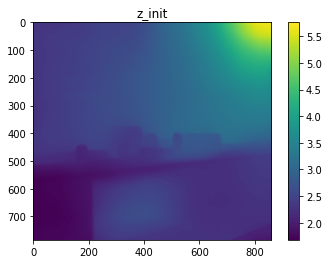

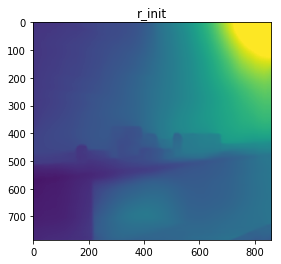

In [12]:
# Run RGB through CNN
midas_model = get_midas(model_path="MiDaS/model.pt", device="cpu")
z_init = midas_predict(midas_model, rgb_cropped/255., depth_range=(min_depth, max_depth), device="cpu")
plt.figure()
plt.imshow(z_init, vmin=min_depth, vmax=max_depth)
plt.title("z_init")
plt.colorbar()

# Convert to radial distance
r_init = z_to_r_kinect(z_init)
plt.figure()
plt.imshow(r_init, vmin=min_depth, vmax=max_depth)
plt.title("r_init")


In [36]:
def find_movement(hist_from, hist_to):
    """Gives the movements from hist_from (column sum)
    to hist_to (row sum).

    Based on Morovic et. al 2002 A fast, non-iterative, and exact histogram matching algorithm.

    hist_from and hist_to should sum to the same value
    """
    movement = np.zeros((len(hist_from), len(hist_to)))
    for row in range(len(hist_from)):
        for col in range(len(hist_to)):
            pixels_rem = hist_from[row] - np.sum(movement[row, :col])
            pixels_req = hist_to[col] - np.sum(movement[:row, col])
            # if np.minimum(pixels_rem, pixels_req) < 0:
            #     print(row, col)
            #     print(hist_from[row])
            #     print(hist_to[col])
            #     print(pixels_rem, pixels_req)
            #     raise Exception()
            movement[row, col] = np.clip(np.minimum(pixels_rem, pixels_req), a_min=0., a_max=None)
    return movement


def move_pixels(T, init_index, weights):
    assert init_index.shape == weights.shape
    pred_index = np.zeros_like(init_index)
    cpfs = np.cumsum(T, axis=1)

    
    for row in range(init_index.shape[0]):
        for col in range(init_index.shape[1]):
            i = init_index[row, col]
            cpf = cpfs[i]
            p = np.random.uniform(0, cpf[-1])
            for j in range(len(cpf)):
                if cpf[j] >= p:
                    pred_index[row, col] = j
                    if T[i,j] > weights[row, col]:
                        # Leave some small positive mass here so that future pixels don't clip to 0.
                        T[i, j] = T[i, j] - weights[row, col]
                    break
    return pred_index


def move_pixels_vectorized(T, init_index, weights):
    assert init_index.shape == weights.shape
    pred_index = np.zeros_like(init_index)
    cpfs = np.cumsum(T, axis=1)  # Sum across columns
    pixel_cpfs = cpfs[init_index, :]  # Per-pixel cpf, cpf goes along axis 2
    p = np.random.uniform(0., pixel_cpfs[..., -1], size=init_index.shape)  # Generate 1 random number for each pixel
    # Use argmax trick to get first index k where p[i,j] < pixel_cpfs[i,j,k] for all i,j
    pred_index = (np.expand_dims(p, 2) < pixel_cpfs).argmax(axis=2)
    return pred_index

def image_histogram_match(init, gt_hist, weights, sid_obj):
    weights = weights * (np.sum(gt_hist) / np.sum(weights))
    init_index = np.clip(sid_obj.get_sid_index_from_value(init), a_min=0, a_max=sid_obj.sid_bins - 1)
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(sid_obj.sid_bins + 1))
    if (gt_hist < 0).any():
        print("Negative values in gt_hist")
        raise Exception()
    T_count = find_movement(init_hist, gt_hist)
#     pred_index = move_pixels_raster(T_count, init_index, weights)
#     pred_index = move_pixels(T_count, init_index, weights)
#     pred_index = move_pixels_better(T_count, init_index, weights)
    pred_index = move_pixels_vectorized(T_count, init_index, weights)
    pred = sid_obj.get_value_from_sid_index(pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights, bins=range(len(gt_hist) + 1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)

def image_histogram_match_lin(init, gt_hist, weights, min_depth, max_depth):
    weights = weights * (np.sum(gt_hist) / np.sum(weights))
    n_bins = len(gt_hist)
    bin_edges = np.linspace(min_depth, max_depth, n_bins + 1)
    bin_values = (bin_edges[1:] + bin_edges[:-1])/2
    init_index = np.clip(np.floor((init - min_depth)*n_bins/(max_depth - min_depth)),
                         a_min=0., a_max=n_bins-1).astype('int')
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(n_bins+1))
    if (gt_hist < 0).any():
        print("Negative values in gt_hist")
        raise Exception()
    T_count = find_movement(init_hist, gt_hist)
#     pred_index = move_pixels_raster(T_count, init_index, weights)
#     pred_index = move_pixels(T_count, init_index, weights)
#     pred_index = move_pixels_better(T_count, init_index, weights)
    pred_index = move_pixels_vectorized(T_count, init_index, weights)
    pred = np.take(bin_values, pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights, bins=range(n_bins+1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)

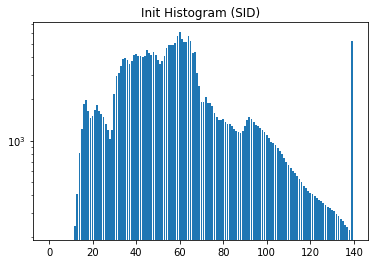

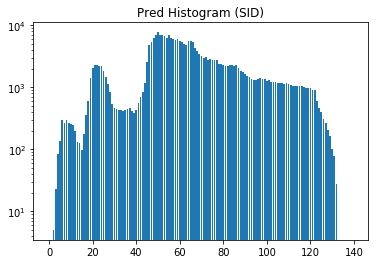

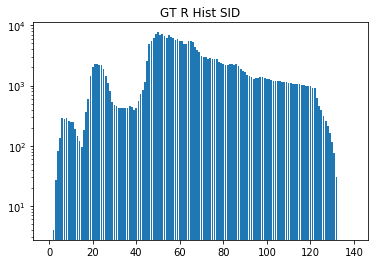

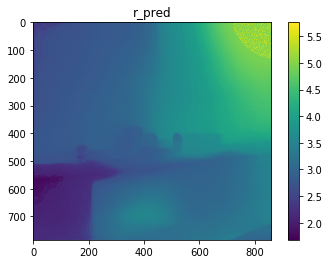

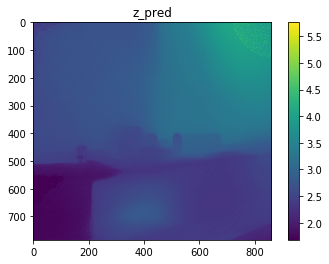

In [49]:
# Histogram match r_init to spad corrected sid
# Hack: Zero out last two nonzero entries of the spad_sid
# bad_indices = np.sort(np.nonzero(spad_sid))[0][-2:]
bad_indices = np.where(np.abs(log_diff_sid) > 10.)
spad_sid_hack = spad_sid.copy()
spad_sid_hack[bad_indices] = 0.
# Perform histogram matching
weights = intensity * cv2.resize(normals, (intensity.shape[1], intensity.shape[0]))
# r_pred, t = image_histogram_match(r_init, spad_sid, weights, sid_obj)
# r_pred, t = image_histogram_match_lin(r_init, spad_corrected, weights, min_depth, max_depth)
r_pred, t = image_histogram_match(r_init, gt_r_hist_sid, np.ones_like(r_init), sid_obj)
# r_pred, t = image_histogram_match_lin(r_init, gt_r_hist, np.ones_like(r_init), min_depth, max_depth)
init_hist = t[1]
pred_hist = t[3]
z_pred = r_to_z_kinect(r_pred)
# r_pred, _ = image_histogram_match(r_init, spad_sid, np.ones_like(r_init), sid_obj)
plt.figure()
plt.bar(range(len(init_hist)), init_hist, log=True)
plt.title("Init Histogram (SID)")
plt.figure()
plt.bar(range(len(pred_hist)), pred_hist, log=True)
plt.title("Pred Histogram (SID)")
plt.figure()
plt.bar(range(len(gt_r_hist_sid)), gt_r_hist_sid, log=True)
plt.title("GT R Hist SID")
plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.title("r_pred")
plt.colorbar()
plt.figure()
plt.imshow(z_pred, vmin=min_depth, vmax=max_depth)
plt.title("z_pred")
plt.colorbar()





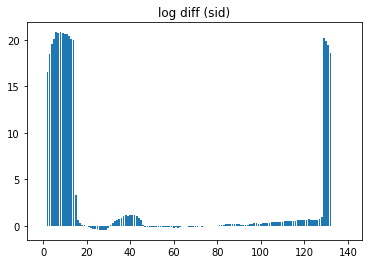

In [23]:
# Log diff sid
log_diff_sid = np.log(gt_r_hist_sid + 1e-3) - np.log(spad_sid_hack + 1e-3)
plt.figure()
plt.bar(range(len(log_diff_sid)), log_diff_sid)
plt.title("log diff (sid)");

In [39]:
def hist_match(source, template):
    """
    From https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x

    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

Before:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.8540,     0.9941,     1.0000,     0.2684,     0.4672,     0.0643
Median:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.9547,     0.9945,     0.9999,     0.2294,     0.3565,     0.0312
GT Histogram Matching:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.9685,     0.9945,     0.9999,     0.1911,     0.2518,     0.0258
After:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.9029,     0.9991,     1.0000,     0.2103,     0.3778,     0.0445
Standard Dev. of scene: 0.6082233843019977


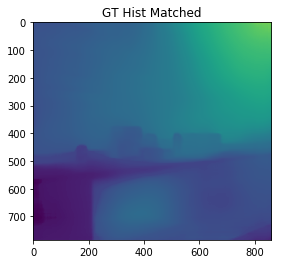

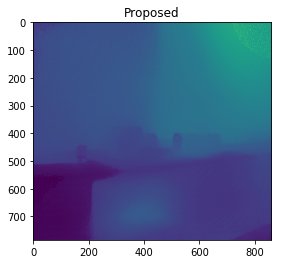

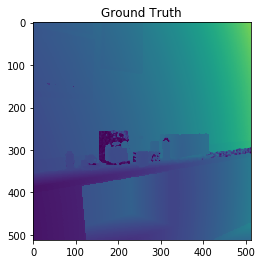

In [44]:
# Calculate metrics, plot results, generate figures
import torch
import cv2
from models.loss import get_depth_metrics
def pprint_metrics(metrics):
    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('d1', 'd2', 'd3', 'rel', 'rmse', 'log_10'))
    print(
        "{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(metrics["delta1"],
                                                                            metrics["delta2"],
                                                                            metrics["delta3"],
                                                                            metrics["rel_abs_diff"],
                                                                            metrics["rmse"],
                                                                            metrics["log10"]))

    
mask = np.ones_like(gt_z)
gt_z[gt_z == 0] = 1e-3  # Clip to avoid numerical issues

z_pred_resized = cv2.resize(z_pred, gt_z.shape)
pred_metrics = get_depth_metrics(torch.from_numpy(z_pred_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())

z_median = z_init*np.median(gt_z)/np.median(z_init)
z_median_resized = cv2.resize(z_median, gt_z.shape)
median_metrics = get_depth_metrics(torch.from_numpy(z_median_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())

z_matched = hist_match(z_init, gt_z)
z_matched_resized = cv2.resize(z_matched, gt_z.shape)
matched_metrics = get_depth_metrics(torch.from_numpy(z_matched_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())

plt.figure()
plt.imshow(z_matched, vmin=min_depth, vmax=max_depth)
plt.title("GT Hist Matched")


z_init_resized = cv2.resize(z_init, gt_z.shape)
init_metrics = get_depth_metrics(torch.from_numpy(z_init_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())

plt.figure()
plt.imshow(z_pred, vmin=min_depth, vmax=max_depth)
plt.title("Proposed")

    
    
plt.figure()
plt.imshow(gt_z, vmin=min_depth, vmax=max_depth)
plt.title("Ground Truth")

print("Before:")
pprint_metrics(init_metrics)

print("Median:")
pprint_metrics(median_metrics)

print("GT Histogram Matching:")
pprint_metrics(matched_metrics)

print("After:")
pprint_metrics(pred_metrics)

print("Standard Dev. of scene: {}".format(np.std(gt_z[mask > 0.])))





[   0.          7.970459   15.986267   24.04779    32.155396   40.30896
   48.509155   56.75586    65.0495     73.390686   81.779175   90.215576
   98.69989   107.232666  115.813965  124.44403   133.12354   141.85223
  150.63098   159.45935   168.3382    177.2677    186.24805   195.27936
  204.36218   213.49695   222.68335   231.9226    241.21411   250.5586
  259.95648   269.40778   278.9129    288.47223   298.08618   307.75458
  317.4782    327.25726   337.09174   346.98248   356.92963   366.9333
  376.99396   387.112     397.2879    407.52155   417.8133    428.16376
  438.57343   449.04218   459.57062   470.15912   480.8078    491.51727
  502.28778   513.11957   524.01276   534.9683    545.98627   557.0672
  568.211     579.41815   590.6893    602.0246    613.42474   624.88947
  636.4195    648.01544   659.6774    671.4057    683.20074   695.06305
  706.993     718.99115   731.0572    743.1921    755.3963    767.66986
  780.0135    792.4272    804.9119    817.46735   830.0948    842.

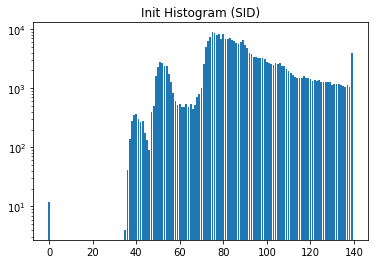

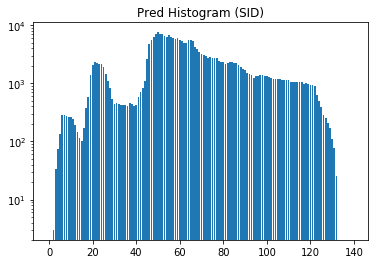

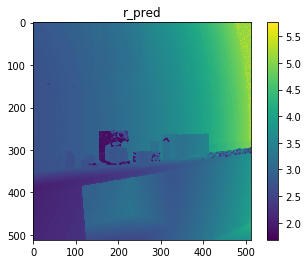

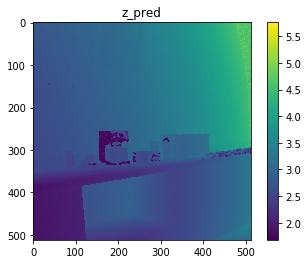

In [24]:
# Try Histogram matching a shifted version of ground truth.
# Histogram match r_init to spad corrected sid
# Perform histogram matching
weights = intensity * cv2.resize(normals, (intensity.shape[1], intensity.shape[0]))
gt_r_hist_sid = rescale_bins(gt_r_hist, min_depth, max_depth, sid_obj)
r_pred, t = image_histogram_match(gt_r + 0.7, gt_r_hist_sid, np.ones_like(gt_r), sid_obj)
init_hist = t[1]
pred_hist = t[3]
z_pred = r_to_z_kinect(r_pred)
# r_pred, _ = image_histogram_match(r_init, spad_sid, np.ones_like(r_init), sid_obj)
plt.figure()
plt.bar(range(len(init_hist)), init_hist, log=True)
plt.title("Init Histogram (SID)")
plt.figure()
plt.bar(range(len(pred_hist)), pred_hist, log=True)
plt.title("Pred Histogram (SID)")
plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.title("r_pred")
plt.colorbar()
plt.figure()
plt.imshow(z_pred, vmin=min_depth, vmax=max_depth)
plt.title("z_pred")
plt.colorbar()